In [22]:

#from __future__ import print_function
import os
from statsmodels.compat import urlopen
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import statsmodels.api as sm
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm


In [28]:

import h5py
import os
import json

import pandas as pd
import numpy as np
import pylab as pl
import matplotlib as mpl
import seaborn as sns

import pyvttbl as pt
from collections import namedtuple


from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


from pipeline.python.utils import natural_keys
import pipeline.python.traces.combine_runs as cb
import pipeline.python.paradigm.align_acquisition_events as acq


/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [23]:
%matplotlib inline

### Load sample data:

In [24]:

try:
    salary_table = pd.read_csv('salary.table')
except:  # recent pandas can read URL without urlopen
    url = 'http://stats191.stanford.edu/data/salary.table'
    fh = urlopen(url)
    salary_table = pd.read_table(fh)
    salary_table.to_csv('salary.table')

E = salary_table.E
M = salary_table.M
X = salary_table.X
S = salary_table.S

In [25]:
salary_table

,Unnamed: 0,S,X,E,M
0,0,13876,1,1,1
1,1,11608,1,3,0
2,2,18701,1,3,1
3,3,11283,1,2,0
4,4,11767,1,3,0
5,5,20872,2,2,1
6,6,11772,2,2,0
7,7,10535,2,1,0
8,8,12195,2,3,0
9,9,12313,3,2,0


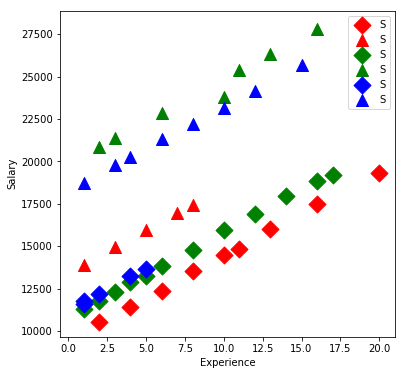

In [26]:
plt.figure(figsize=(6,6))
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
factor_groups = salary_table.groupby(['E','M'])
for values, group in factor_groups:
    i,j = values
    plt.scatter(group['X'], group['S'], marker=symbols[j], color=colors[i-1],
               s=144)
plt.xlabel('Experience');
plt.ylabel('Salary');
plt.legend()

### Format data similarly:

##### Don't filter trials with pupil info to match N reps per combination:

In [95]:
reload(acq)
reload(cb)

<module 'pipeline.python.traces.combine_runs' from '/home/juliana/Repositories/2p-pipeline/pipeline/python/traces/combine_runs.py'>

In [96]:

rootdir = '/mnt/odyssey'
animalid = 'CE074' #'CE077'
session = '20180215' #'20180321'
acquisition = 'FOV1_zoom1x_V1' #'FOV1_zoom1x'
rundir = 'gratings_phasemod'# 'blobs_run3_blobs_run4'
tracedir =  'traces/traces004_c04dde' #'traces002_traces002'

trace_type = 'raw'
filter_pupil = False
pupil_radius_min = 20
pupil_radius_max = 60
pupil_dist_thr = 3.0

traceid_dir = os.path.join(rootdir, animalid, session, acquisition, rundir, tracedir)
print(traceid_dir)

#%% # Load ROIDATA file:
roidf_fn = [i for i in os.listdir(traceid_dir) if i.endswith('hdf5') and 'ROIDATA' in i][0]
roidata_filepath = os.path.join(traceid_dir, roidf_fn) #'ROIDATA_098054_626d01_raw.hdf5')
DATA = pd.HDFStore(roidata_filepath, 'r')
datakeys = DATA.keys()
if 'roi' not in datakeys[0]:
    print("Found %i data keys" % len(datakeys))
    if len(datakeys) == 1:
        datakey = datakeys[0]
    print("Loading dataframe...")
    DATA = DATA[datakey]

#%% Set filter params:

if filter_pupil is True:
    pupil_params = acq.set_pupil_params(radius_min=pupil_radius_min,
                                        radius_max=pupil_radius_max,
                                        dist_thr=pupil_dist_thr,
                                        create_empty=False)
elif filter_pupil is False:
    pupil_params = acq.set_pupil_params(create_empty=True)

#%% Calculate metrics & get stats ---------------------------------------------

STATS, stats_filepath = cb.get_combined_stats(DATA, datakey, traceid_dir, trace_type=trace_type, filter_pupil=filter_pupil, pupil_params=pupil_params)


/mnt/odyssey/CE074/20180215/FOV1_zoom1x_V1/gratings_phasemod/traces/traces004_c04dde
Requested METRIC: unfiltered_2513448523829438896
Found metrics: ['unfiltered_2513448523829438896']
Renaming metric description string to existing.
Renamed hash to match existing.
Saved roiparams to .json
Loading existing combined METRICS...
C stats path: /mnt/odyssey/CE074/20180215/FOV1_zoom1x_V1/gratings_phasemod/traces/traces004_c04dde/metrics/unfiltered_2513448523829438896/roi_stats_2513448523829438896_raw_20180409121859.hdf5
/roi00001
/roi00002
/roi00003
/roi00004
/roi00005
/roi00006
/roi00007
/roi00008
/roi00009
/roi00010
/roi00011
/roi00012
/roi00013
/roi00014
/roi00015
/roi00016
/roi00017
/roi00018
/roi00019
/roi00020
/roi00021
/roi00022
/roi00023
/roi00024
/roi00025
/roi00026
/roi00027
/roi00028
/roi00029
/roi00030
/roi00031
/roi00032
/roi00033
/roi00034
/roi00035
/roi00036
/roi00037
/roi00038
/roi00039
/roi00040
/roi00041
/roi00042
/roi00043
/roi00044
/roi00045
/roi00046
/roi00047
/roi00048
/r

/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/pandas/core/generic.py:1282: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['config', 'roi', 'trial']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [351]:

trial_list = sorted(list(set(STATS['trial'])), key=natural_keys)
roi_list = sorted(list(set(STATS['roi'])), key=natural_keys)

roi = roi_list[8]
print(roi)
roiSTATS = STATS[STATS['roi']==roi]
grouped = roiSTATS.groupby(['config', 'trial']).agg({'stim_df': 'mean',
                                                         'baseline_df': 'mean'
                                                        }).dropna()

#rstats_df = roiSTATS[['config', 'trial', 'baseline_df', 'stim_df', 'xpos', 'ypos', 'morphlevel', 'yrot', 'size']]
rstats_df = roiSTATS[['trial', 'config', 'baseline_df', 'stim_df']].dropna()
newtrials_names = ['trial%05d' % int(i+1) for i in rstats_df.index]
rstats_df.loc[:, 'trial'] = newtrials_names

tmpd = rstats_df.pivot_table(['stim_df', 'baseline_df'], ['config', 'trial']).T

data = []
data.append(pd.DataFrame({'epoch': np.tile('baseline', (len(tmpd.loc['baseline_df'].values),)),
              'df': tmpd.loc['baseline_df'].values,
              'config': [cfg[0] for cfg in tmpd.loc['baseline_df'].index.tolist()],
              'trial': [cfg[1] for cfg in tmpd.loc['baseline_df'].index.tolist()]
              }))
data.append(pd.DataFrame({'epoch': np.tile('stimulus', (len(tmpd.loc['stim_df'].values),)),
              'df': tmpd.loc['stim_df'].values,
              'config': [cfg[0] for cfg in tmpd.loc['baseline_df'].index.tolist()],
              #'trial': ['trial%05d' % int(i+1) for i in range(len(tmpd.loc['baseline_df'].index.tolist()))]
              'trial': [cfg[1] for cfg in tmpd.loc['baseline_df'].index.tolist()]
              }))
data = pd.concat(data)


/roi00009


In [354]:
TBL = data.pivot_table(index='trial', columns=['epoch', 'config'], values='df')

In [310]:
data.df.mean()

0.012480408900712434

In [311]:
data

,config,df,epoch,trial
0,config001,1.590549e-16,baseline,trial00001
1,config001,1.754769e-16,baseline,trial00002
2,config001,-2.610566e-16,baseline,trial00003
3,config001,4.342591e-17,baseline,trial00004
4,config001,4.086238e-17,baseline,trial00005
5,config001,5.026843e-17,baseline,trial00006
6,config001,1.550169e-16,baseline,trial00007
7,config001,-1.518847e-16,baseline,trial00008
8,config001,-2.837237e-17,baseline,trial00009
9,config001,3.316791e-16,baseline,trial00010


In [312]:
rstats_df

,trial,config,baseline_df,stim_df
0,trial00001,config001,1.590549e-16,-0.014847
1,trial00002,config001,1.754769e-16,0.002605
2,trial00003,config001,-2.610566e-16,0.057080
3,trial00004,config001,4.342591e-17,0.063797
4,trial00005,config001,4.086238e-17,0.041255
5,trial00006,config001,5.026843e-17,0.036067
6,trial00007,config001,1.550169e-16,-0.018069
7,trial00008,config001,-1.518847e-16,0.076798
8,trial00009,config001,-2.837237e-17,0.180283
9,trial00010,config001,3.316791e-16,0.035287


In [489]:
# trial_list = [len(sorted(list(set(data[data['config']==config].trial)), key=natural_keys)) for config in list(set(data.config))]
# trial_list[0]
#trial_list = [(sorted(list(set(data[data['config']==config].trial)), key=natural_keys)) for config in list(set(data.config))]
trial_list =  sorted(list(set(data.trial)), key=natural_keys)
trial_list

['trial00001',
 'trial00002',
 'trial00003',
 'trial00004',
 'trial00005',
 'trial00006',
 'trial00007',
 'trial00008',
 'trial00009',
 'trial00010',
 'trial00011',
 'trial00012',
 'trial00013',
 'trial00014',
 'trial00015',
 'trial00016',
 'trial00017',
 'trial00018']

# Test with RPY

In [298]:
%load_ext rpy2.ipython

In [314]:
epoch_vars = ['a', 'b']
config_vars = [str(int(i+1)) for i in range(len(config_list))]
print(config_vars)
epoch_list = sorted(list(set(data.epoch)), key=natural_keys)
config_list = sorted(list(set(data.config)), key=natural_keys)

['1', '2', '3', '4', '5', '6', '7', '8']


In [315]:
for ei, epoch in enumerate(epoch_list):
    factor_a_var = epoch_vars[ei]
    for ci, config in enumerate(config_list):
        factor_b_var = config_vars[ci]
        cstring = 'cond_%s%s' % (factor_b_var, factor_a_var)
        print(cstring, epoch, config)
        dfvalues = data[((data['config']==config) & (data['epoch']==epoch))]['df'].values
        #exec("%s=dfvalues" % (cstring)) #, dfvalues))
        globals()[cstring] = dfvalues

cond_1a baseline config001
cond_2a baseline config002
cond_3a baseline config003
cond_4a baseline config004
cond_5a baseline config005
cond_6a baseline config006
cond_7a baseline config007
cond_8a baseline config008
cond_1b stimulus config001
cond_2b stimulus config002
cond_3b stimulus config003
cond_4b stimulus config004
cond_5b stimulus config005
cond_6b stimulus config006
cond_7b stimulus config007
cond_8b stimulus config008


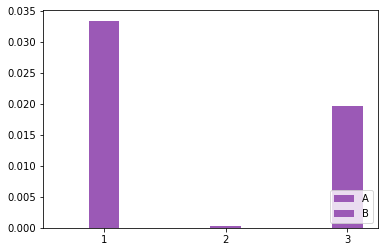

In [316]:
width = 0.25
pl.bar(np.arange(1,4)-width,[np.mean(cond_1a),np.mean(cond_2a),np.mean(cond_3a)],width)
pl.bar(np.arange(1,4),[np.mean(cond_1b),np.mean(cond_2b),np.mean(cond_3b)],width,color=pl.rcParams['axes.color_cycle'][0])
pl.legend(['A','B'],loc=4)
pl.xticks([1,2,3]);

In [317]:
%Rpush cond_1a cond_1b cond_2a cond_2b cond_3a cond_3b cond_4a cond_4b cond_5a cond_5b cond_6a cond_6b cond_7a cond_7b cond_8a cond_8b

%R Factor1 <- c('A','A','A','A','A','A','A','A','B','B','B','B','B','B','B','B')
%R Factor2 <- c('Cond1','Cond2','Cond3','Cond4','Cond5','Cond6','Cond7','Cond8','Cond1','Cond2','Cond3','Cond4','Cond5','Cond6','Cond7','Cond8')
%R idata <- data.frame(Factor1, Factor2)


,Factor1,Factor2
1,A,Cond1
2,A,Cond2
3,A,Cond3
4,A,Cond4
5,A,Cond5
6,A,Cond6
7,A,Cond7
8,A,Cond8
9,B,Cond1
10,B,Cond2


In [318]:

#make sure the vectors appear in the same order as they appear in the dataframe
%R Bind <- cbind(cond_1a, cond_2a, cond_3a, cond_4a, cond_5a, cond_6a, cond_7a, cond_8a, cond_1b, cond_2b, cond_3b, cond_4b, cond_5b, cond_6b, cond_7b, cond_8b)

%R model <- lm(Bind~1)

%R library(car)
%R analysis <- Anova(model, idata=idata, idesign=~Factor1*Factor2, type="III")
%R anova_sum = summary(analysis)
%Rpull anova_sum

print(anova_sum)


Type III Repeated Measures MANOVA Tests:

------------------------------------------
 
Term: (Intercept) 

 Response transformation matrix:
        (Intercept)
cond_1a           1
cond_2a           1
cond_3a           1
cond_4a           1
cond_5a           1
cond_6a           1
cond_7a           1
cond_8a           1
cond_1b           1
cond_2b           1
cond_3b           1
cond_4b           1
cond_5b           1
cond_6b           1
cond_7b           1
cond_8b           1

Sum of squares and products for the hypothesis:
            (Intercept)
(Intercept)   0.7177449

Multivariate Tests: (Intercept)
                 Df test stat approx F num Df den Df    Pr(>F)    
Pillai            1 0.6357392 29.66986      1     17 4.349e-05 ***
Wilks             1 0.3642608 29.66986      1     17 4.349e-05 ***
Hotelling-Lawley  1 1.7452857 29.66986      1     17 4.349e-05 ***
Roy               1 1.7452857 29.66986      1     17 4.349e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘

In [319]:
%R tuk<- TukeyHSD(analysis)



Error in UseMethod("TukeyHSD") : 
  no applicable method for 'TukeyHSD' applied to an object of class "Anova.mlm"


/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in UseMethod("TukeyHSD") : 
  no applicable method for 'TukeyHSD' applied to an object of class "Anova.mlm"

  warnings.warn(x, RRuntimeWarning)
/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In summary.Anova.mlm(analysis) :
  warnings.warn(x, RRuntimeWarning)
/home/juliana/anaconda/envs/rpy/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  HF eps > 1 treated as 1

  warnings.warn(x, RRuntimeWarning)


In [320]:
data

,config,df,epoch,trial
0,config001,1.590549e-16,baseline,trial00001
1,config001,1.754769e-16,baseline,trial00002
2,config001,-2.610566e-16,baseline,trial00003
3,config001,4.342591e-17,baseline,trial00004
4,config001,4.086238e-17,baseline,trial00005
5,config001,5.026843e-17,baseline,trial00006
6,config001,1.550169e-16,baseline,trial00007
7,config001,-1.518847e-16,baseline,trial00008
8,config001,-2.837237e-17,baseline,trial00009
9,config001,3.316791e-16,baseline,trial00010


# STATSMODELS

In [460]:
cw_lm=ols('df ~ C(epoch) + C(config)', data=data).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=3))

             sum_sq     df          F        PR(>F)
Intercept  0.000570    1.0   0.400128  5.275414e-01
C(epoch)   0.044859    1.0  31.492720  4.825306e-08
C(config)  0.016556    7.0   1.660369  1.186874e-01
Residual   0.397415  279.0        NaN           NaN


# PYVTTBL: wooot

In [461]:
import pyvttbl as pt
from collections import namedtuple

#### This is an example to test how this works:

In [527]:
N = 20
P = ['a','b'] #[1,2]
Q = ['x','y','z'] #[1,2,3]
 
values = [[998,511], [1119,620], [1300,790]]
 
sub_id = [i+1 for i in xrange(N)]*(len(P)*len(Q))
mus = np.concatenate([np.repeat(value, N) for value in values]).tolist()
rt = np.random.normal(mus, scale=112.0, size=N*len(P)*len(Q)).tolist()
iv1 = np.concatenate([np.array([p]*N) for p in P]*len(Q)).tolist()
iv2 = np.concatenate([np.array([q]*(N*len(P))) for q in Q]).tolist()
 
 
Sub = namedtuple('Sub', ['Sub_id', 'rt','iv1', 'iv2'])               
df = pt.DataFrame()
for idx in xrange(len(sub_id)):
    df.insert(Sub(sub_id[idx],rt[idx], iv1[idx],iv2[idx])._asdict())    

# Plot by factors:
pl.figure()
df.box_plot('rt', factors=['iv1', 'iv2'])
pl.show()

# Do ANOVA:
aov = df.anova('rt', sub='Sub_id', wfactors=['iv1', 'iv2'])
print(aov)

rt ~ iv1 * iv2

TESTS OF WITHIN SUBJECTS EFFECTS

Measure: rt
  Source                            Type III      eps      df         MS           F        Sig.      et2_G   Obs.     SE     95% CI    lambda    Obs.  
                                       SS                                                                                                         Power 
iv1           Sphericity Assumed   8537154.798       -        1   8537154.798   572.379   1.199e-15   5.987     60   16.837   33.000   1807.511       1 
              Greenhouse-Geisser   8537154.798       1        1   8537154.798   572.379   1.199e-15   5.987     60   16.837   33.000   1807.511       1 
              Huynh-Feldt          8537154.798       1        1   8537154.798   572.379   1.199e-15   5.987     60   16.837   33.000   1807.511       1 
              Box                  8537154.798       1        1   8537154.798   572.379   1.199e-15   5.987     60   16.837   33.000   1807.511       1 
--------------------

### Test with data:

In [532]:
N = len(trial_list)
print("N trials:", N)
P = ['B', 'S']
Q = config_list

trial_id = trial_list*(len(P)*len(Q))

dff = data.df

epochs = np.concatenate([np.array([p]*N) for p in P]*len(Q)).tolist()
configs = np.concatenate([np.array([q]*(N*len(P))) for q in Q]).tolist()

Sub = namedtuple('Trial', ['trial', 'dff','epoch', 'config'])               

pdf = pt.DataFrame()
for idx in xrange(len(trial_id)):
    if epochs[idx]=='B':
        epoch_type = 'baseline'
    else:
        epoch_type = 'stimulus'
        
    dff_value = data[((data['config']==configs[idx]) & (data['epoch']==epoch_type) & (data['trial']==trial_id[idx]))]['df'].values[0]
    pdf.insert(Sub(trial_id[idx], dff_value, epochs[idx],configs[idx])._asdict())    
#pdf

N trials: 18


In [533]:
pdf.box_plot('dff', factors=['epoch', 'config'])

In [534]:

anova_results = pdf.anova('dff', sub='trial', wfactors=['epoch', 'config'])
print(anova_results)

dff ~ epoch * config

TESTS OF WITHIN SUBJECTS EFFECTS

Measure: dff
   Source                            Type III    eps      df      MS       F        Sig.      et2_G   Obs.    SE     95% CI   lambda    Obs.  
                                        SS                                                                                              Power 
epoch           Sphericity Assumed      0.045       -        1   0.045   29.670   4.349e-05   0.118    144   0.003    0.007   251.321       1 
                Greenhouse-Geisser      0.045       1        1   0.045   29.670   4.349e-05   0.118    144   0.003    0.007   251.321       1 
                Huynh-Feldt             0.045       1        1   0.045   29.670   4.349e-05   0.118    144   0.003    0.007   251.321       1 
                Box                     0.045       1        1   0.045   29.670   4.349e-05   0.118    144   0.003    0.007   251.321       1 
-------------------------------------------------------------------------

In [535]:
aov = pdf.anova('dff', sub='trial',
                   wfactors=['epoch'],
                   bfactors=['config'])
print(aov)

dff ~ epoch * config

TESTS OF BETWEEN-SUBJECTS EFFECTS

Measure: dff
     Source        Type III   df     MS       F      Sig.   et2_G    Obs.    SE   95% CI   lambda   Obs.  
                      SS                                                                            Power 
Between Subjects      0.003   15                                                                          
config                0.132    7    0.019   -1.171      1   -0.276   2.250   --       --   -2.306      -- 
Error                -0.129    8   -0.016                                                                 

TESTS OF WITHIN SUBJECTS EFFECTS

Measure: dff
    Source                            Type III    eps     df       MS       F      Sig.   et2_G    Obs.    SE   95% CI   lambda    Obs.  
                                         SS                                                                                        Power 
epoch            Sphericity Assumed      0.359       -       1    0.359

In [536]:
for d in aov:
    print(d)

('epoch',)
('config',)
('epoch', 'config')
('trial',)
('TOTAL',)
('WITHIN',)
('epoch', 'trial')


#### Try using more built-in methods:

In [549]:
from pyvttbl import stats, Anova


In [565]:
N = len(trial_list)
print("N trials:", N)
P = ['B', 'S']
Q = config_list

trial_id = trial_list*(len(P)*len(Q))

dff = data.df

epochs = np.concatenate([np.array([p]*N) for p in P]*len(Q)).tolist()
configs = np.concatenate([np.array([q]*(N*len(P))) for q in Q]).tolist()

Sub = namedtuple('Trial', ['trial', 'dff','epoch', 'config'])               

pdf = pt.DataFrame()
for idx in xrange(len(trial_id)):
    if epochs[idx]=='B':
        epoch_type = 'baseline'
    else:
        epoch_type = 'stimulus'
        
    dff_value = data[((data['config']==configs[idx]) & (data['epoch']==epoch_type) & (data['trial']==trial_id[idx]))]['df'].values[0]
    pdf.insert(Sub(trial_id[idx], dff_value, epochs[idx],configs[idx])._asdict())    
#pdf

N trials: 18


In [557]:
aov = stats.Anova()
#aov.run(pdf, 'dff', sub='trial', wfactors=['epoch'], bfactors=['config'])
aov.run(pdf, 'dff', sub='trial', bfactors=['config'])

print(aov)

dff ~ config

TESTS OF BETWEEN-SUBJECTS EFFECTS

Measure: dff
Source   Type III   df       MS         F        Sig.      et2_G   Obs.     SE     95% CI   lambda   Obs.  
            SS                                                                                       Power 
config      0.066     7       0.009   71.072   1.909e-58   0.640   2.250   0.008    0.015    3.998   0.246 
Error       0.037   280   1.331e-04                                                                        
Total       0.459   287                                                                                    

TABLES OF ESTIMATED MARGINAL MEANS

Estimated Marginal Means for config
 config       Mean      Std. Error   95% Lower Bound   95% Upper Bound 
config001       0.017        0.007             0.003             0.031 
config002   1.509e-04        0.004            -0.007             0.007 
config003       0.010        0.005         2.914e-04             0.019 
config004       0.004        0.005   

In [558]:
aov[aov.keys()[0]]

{'F': 71.071704752582406,
 'ci': 0.015140562472344578,
 'critT': 1.9684724997365923,
 'df': 7.0,
 'dfe': 280.0,
 'eta': 0.63987227810087244,
 'lambda': 3.9977833923327601,
 'mse': 0.00013310912644596927,
 'mss': 0.0094602925346420862,
 'obs': 2.25,
 'p': 1.9085708231970284e-58,
 'power': 0.2460186773206513,
 'se': 0.0077247767716043768,
 'ss': 0.0662220477424946,
 'sse': 0.037270555404871397,
 'y2': array([ 0.0167,  0.0002,  0.0098,  0.0042,  0.0128,  0.0152,  0.0143,
         0.0267])}

### Take CONFIG as between-subjects factor in 1-way:

In [560]:
from pyvttbl import Anova1way


In [576]:
N = len(trial_list)
print("N trials:", N)
P = ['S']
Q = config_list

trial_id = trial_list*(len(P)*len(Q))

dff = data.df

epochs = np.concatenate([np.array([p]*N) for p in P]*len(Q)).tolist()
configs = np.concatenate([np.array([q]*(N*len(P))) for q in Q]).tolist()

Sub = namedtuple('Trial', ['trial', 'dff','config'])               

data_list = [] #pt.DataFrame()
data_list = [data[((data['config']==config) & (data['epoch']=='stimulus'))]['df'].values.tolist() for config in config_list]


N trials: 18


In [577]:
data[((data['config']==config) & (data['epoch']=='stimulus'))]['df'].values.tolist()

[-0.053910849207779846,
 0.04576803524197063,
 -0.006054034119431786,
 0.13901373810038406,
 0.021123581806634133,
 0.057454789456487236,
 -0.027423221919483872,
 -0.01467811232938793,
 0.004224086222455139,
 0.002216715727477073,
 0.24502487306518875,
 0.02670583506936013,
 0.035358131153040206,
 0.052344276666109045,
 0.23625787093414893,
 -0.02452519639184093,
 0.22476542406561464,
 -0.0012556332925900177]

In [578]:
data[((data['config']==configs[idx]) & (data['epoch']=='stimulus'))]['df'].values

array([-0.0539,  0.0458, -0.0061,  0.139 ,  0.0211,  0.0575, -0.0274,
       -0.0147,  0.0042,  0.0022,  0.245 ,  0.0267,  0.0354,  0.0523,
        0.2363, -0.0245,  0.2248, -0.0013])

In [579]:
D = Anova1way()
D.run(data_list, conditions_list=config_list)
print(D)

Anova: Single Factor on Measure

SUMMARY
 Groups     Count    Sum     Average    Variance  
config001      18   0.601       0.033       0.003 
config002      18   0.005   3.017e-04   9.138e-04 
config003      18   0.352       0.020       0.002 
config004      18   0.150       0.008       0.002 
config005      18   0.462       0.026       0.002 
config006      18   0.548       0.030       0.003 
config007      18   0.513       0.029       0.001 
config008      18   0.962       0.053       0.009 

O'BRIEN TEST FOR HOMOGENEITY OF VARIANCE
Source of Variation      SS       df       MS         F     P-value   eta^2   Obs. power 
Treatments            8.290e-04     7   1.184e-04   3.087     0.005   0.137        0.908 
Error                     0.005   136   3.836e-05                                        
Total                     0.006   143                                                    

ANOVA
Source of Variation    SS     df     MS       F     P-value   eta^2   Obs. power 
Treatment

# Manual 2-way ANOVA RM

In [109]:
x = [69, 61, 68, 66, 66, 63, 72, 62, 62, 67, 66, 63]
x = [float(ix) for ix in x]

y = [108, 130, 135, 135, 120, 115, 150, 105, 115, 145, 132, 120]
y = [float(iy) for iy in y]

covxy = np.sum(ix*iy for ix,iy in zip(x, y))


99064.0

In [110]:
def covxy(x, y):
    sum_xy = np.sum(ix*iy for ix,iy in zip(x, y))
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    N = len(x)
    covxy = (sum_xy - (sum_x * sum_y)/N ) / (N - 1)
    return covxy

#### Get DoFs:

In [220]:
ntrials = len(trial_list)
ntrials

18

In [221]:
# factor A = epoch (baseline, stimulus)
# factor B = config (8x)
factor_a = data.epoch.unique()
factor_b = data.config.unique()
total_n = len(factor_a) * len(factor_b) * ntrials

#N = trial_list[0]
df_t = total_n - 1
df_a = len(factor_a) - 1
df_b = len(factor_b) - 1
df_c = ntrials - 1

df_ab = df_a * df_b
df_ac = df_a * df_c
df_bc = df_b * df_c
df_abc = df_a * df_b * df_c

#df_w = N - (len(data.epoch.unique())*len(data.config.unique()))



#### Calculate Sum of squares:

In [222]:
grand_mean = data['df'].mean()  # Grand mean
print(grand_mean)

0.0221898830541


In [223]:
ssq_t = sum((data.df - grand_mean)**2)                                               # Sum of squares total
print(ssq_t)

1.43776439335


In [229]:
#%%
# Calculate sum of squares:

#grand_mean = data['df'].mean()  # Grand mean
ssq_a = (ntrials * len(factor_b)) * sum([(data[data.epoch ==l].df.mean()-grand_mean)**2 for l in factor_a])    # Sum of squares for factor A (trial epoch)
ssq_b = (ntrials * len(factor_a)) * sum([(data[data.config ==l].df.mean()-grand_mean)**2 for l in factor_b])  # Sum of squares for factor B (stim config)
ssq_c = (len(factor_a) * len(factor_b)) * sum([(data[data.trial ==l].df.mean()-grand_mean)**2 for l in trial_list])
ssq_t = sum((data.df - grand_mean)**2)                                               # Sum of squares total


In [265]:
print(np.sum([(data[data.trial ==l].df.mean()-grand_mean)**2 for l in data.trial]))
print(np.sum([(data[data.trial==l].df.mean()-grand_mean)**2 for l in trial_list]))

0.131735104224
0.00823344401403


In [241]:
within_sums = []
for stimconfig in factor_b:
    currconfig = data[data.config == stimconfig]
    currconfig_epoch_means = [currconfig[currconfig.epoch == e].df.mean() for e in factor_a]
    print(currconfig_epoch_means)
    print(len([i for i in currconfig.df if np.isnan(i)]))
    curr_ss = sum([(currconfig.df - m)**2 for m in currconfig_epoch_means])
    within_sums.append(curr_ss)

ssq_w = sum(within_sums)

[5.5923800585887609e-17, 0.034183192686377324]
0
[1.4474768263281784e-17, 0.020388091099603368]
0
[-2.7706318035446854e-17, 0.014808967416293006]
0
[6.459167905612408e-18, 0.039597902053632235]
0
[4.097159854186703e-17, 0.047670950966839508]
0
[4.0728322313658098e-17, 0.051517556168206732]
0
[4.3924911718869542e-18, 0.039906536829949518]
0
[6.6401359719334483e-18, 0.10696493164514734]
0


In [251]:
[(currconfig.df - m)**2 for m in currconfig_epoch_means]

[126    1.802002e-32
 127    7.412290e-34
 128    3.134593e-32
 129    4.680686e-32
 130    1.681446e-32
 131    4.508000e-32
 132    2.105121e-32
 133    1.059199e-33
 134    2.132616e-32
 135    5.969518e-33
 136    2.240054e-34
 137    1.222132e-32
 138    2.789090e-32
 139    4.212993e-33
 140    2.017780e-33
 141    1.042330e-35
 142    4.869369e-32
 143    9.046968e-34
 126    4.810067e-04
 127    8.243320e-04
 128    7.501003e-07
 129    8.823188e-02
 130    2.200456e-02
 131    1.174748e-06
 132    6.723499e-04
 133    3.276864e-02
 134    2.284599e-02
 135    1.069042e-02
 136    1.611312e-04
 137    2.651372e-02
 138    2.397732e-02
 139    1.235909e-01
 140    7.271479e-04
 141    3.870282e-03
 142    1.133653e-02
 143    7.093855e-02
 Name: df, dtype: float64, 126    1.144150e-02
 127    1.144150e-02
 128    1.144150e-02
 129    1.144150e-02
 130    1.144150e-02
 131    1.144150e-02
 132    1.144150e-02
 133    1.144150e-02
 134    1.144150e-02
 135    1.144150e-02
 136    

In [252]:
currconfig_epoch_means

[6.6401359719334483e-18, 0.10696493164514734]

In [338]:
def calc_grandmean(data, columns):
   '''
   Takes a pandas dataframe and calculates the grand mean
   data = dataframe
   columns = list of column names with the response variables
   '''
   gm = np.mean(data[var].mean())
   return gm

grand_mean = calc_grandmean(data, ['df'])
grand_mean

DT = TBL.stack()
DT

sub_means = DT.mean(axis=1)
column_means = DT.mean(axis=0)
n = 18    # num of "subjects"
k = 8 * 2 # num of conditions

ncells =  k * n

dftotal = ncells - 1
dfbw = k - 1
dfsbj = n - 1
dfw = dftotal - dfbw
dferror = dfw - dfsbj


column_means

sub_means

DT

# SS between:
# ... sum of squared deviations of the sample means from the grand mean multiplied by the number of observations
SSbetween = sum(n*[(m - grand_mean)**2 for m in column_means])

# SS within:
# ... sum of squared deviations within each sample
SSwithin = sum(sum([(DT[ep] - column_means[i])**2 for i,ep in enumerate(DT.columns)]))
                                   
# SS subjects : The sum of squared deviations of the subject means from the grand mean
# multiplied by the number of conditions (k)                             
SSsubject = sum(k*[(m -grand_mean)**2 for m in sub_means])

# SS error:
SSerror = SSwithin - SSsubject

# SS total:  sum of squared deviations of all observations from grand mean:
SStotal = SSbetween + SSwithin


print("SS-bw:", SSbetween)
print("SS-within:", SSwithin)
print("SS-subject:", SSsubject)

MSbetween = SSbetween/dfbw
MSerror = SSerror/dferror
F = MSbetween/MSerror

p_value = stats.f.sf(F, 2, dferror)
print(p_value)


dferror

# ##For createing example data
# X1 = [6,4,5,1,0,2]
# X2 = [8,5,5,2,1,3]
# X3 = [10,6,5,3,2,4]

# df = pd.DataFrame({'Subid': xrange(1, len(X1)+1), 'X1':X1, 'X2':X2, 'X3':X3})

# #Grand mean 
# grand_mean = calc_grandmean(df, ['X1', 'X2', 'X3'])
# df['Submean'] = df[['X1', 'X2', 'X3']].mean(axis=1)
# column_means = df[['X1', 'X2', 'X3']].mean(axis=0)

# df

[col for col in enumerate(df[['X1', 'X2', 'X3']])]

df.columns